*This notebook is based on the quicktour in the diffusion area in huggingface - 
https://huggingface.co/docs/diffusers/quicktour*

**Let's start by loading stable-diffusion-v1.5**

In [2]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)
pipeline.to("cuda")



















































































































































































































































































































































Fetching 15 files:  20%|██        | 3/15 [00:18<00:03,  3.88it/s]





































































































































































































































































































































































































































































































Fetching 15 files:  27%|██▋       | 4/15 [00:48<03:02, 16.56s/it]















































StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.20.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


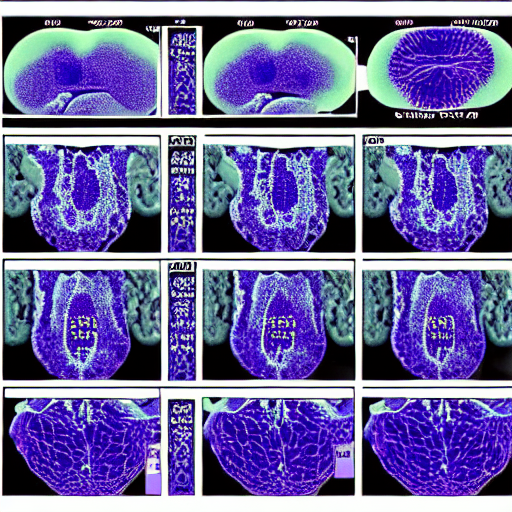

In [4]:
# prompt = "An image of a squirrel in Picasso style"
prompt = "An image of lung ultrasound with viral pneumonia"

image = pipeline(prompt).images[0]
image
# image.save("image_of_squirrel_painting.png")

**Now we start the tutorial from: https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline**

100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


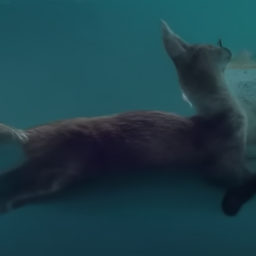

In [3]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

Creating our own pipeline

In [4]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [6]:
scheduler.set_timesteps(50)
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [7]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


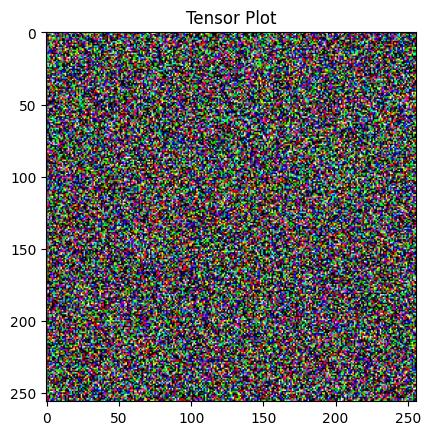

In [10]:
import torch, matplotlib.pyplot as plt

plt.imshow(noise.cpu().squeeze(0).permute(1, 2, 0).detach().numpy())
plt.title('Tensor Plot')
plt.show()


In [14]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

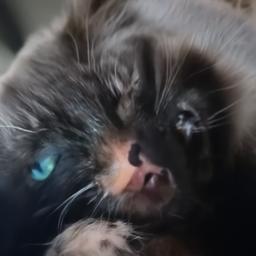

In [15]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

**Now Let's deconstruct stable-siffusion**

In [16]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [17]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [19]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, 

In [20]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [21]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [30]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [33]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [81]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

/tmp/ipykernel_64943/2341608825.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


Plotting the decoded lantents

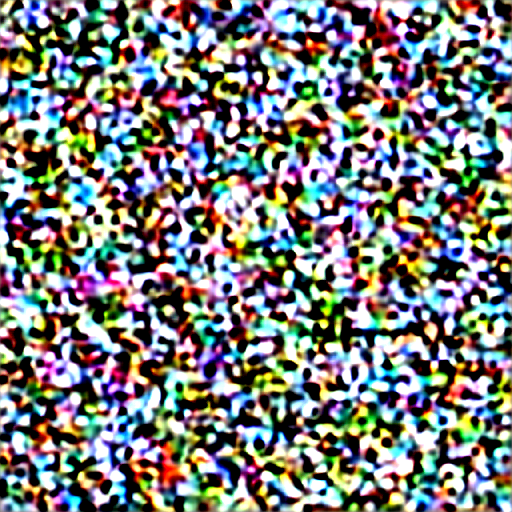

In [60]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image

In [82]:
latents = latents * scheduler.init_noise_sigma

*Original denoising loop*

In [76]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


*Added a plotting function to the denoising process*

  4%|▍         | 1/25 [00:00<00:11,  2.06it/s]

100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


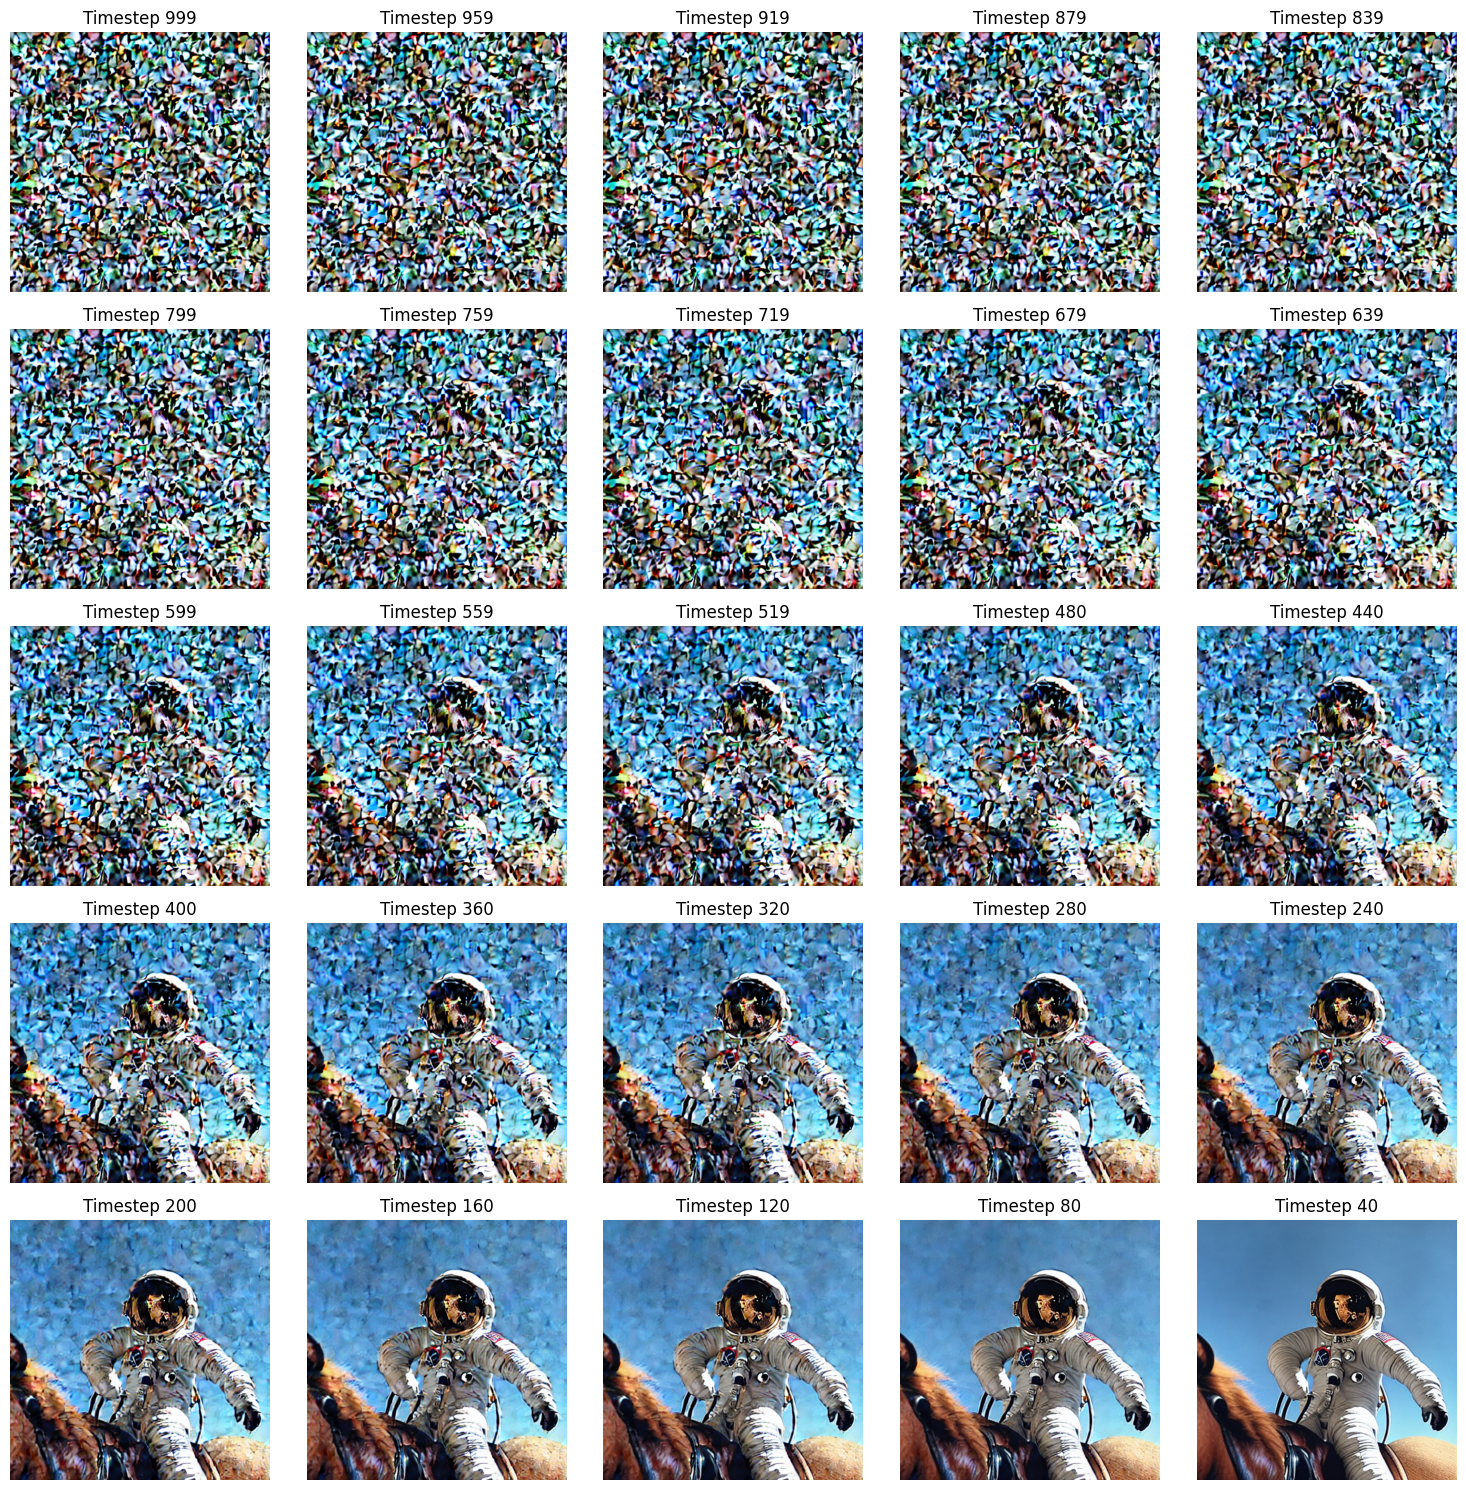

In [83]:
def plot_latents(latents, ax):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    ax.imshow(image)
    ax.set_title(f'Timestep {t}')
    ax.axis('off')

scheduler.set_timesteps(num_inference_steps)


# Initialize a 5x5 figure for subplots
grid_size = 5
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 5x5 grid into a 1D array for easier indexing

for i, t in enumerate(tqdm(scheduler.timesteps)):
    if i >= grid_size * grid_size:
        break  # Stop plotting if we exceed the 5x5 grid size
        
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    plot_latents(latents, axes[i])
    
plt.tight_layout()
plt.show()

In [70]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

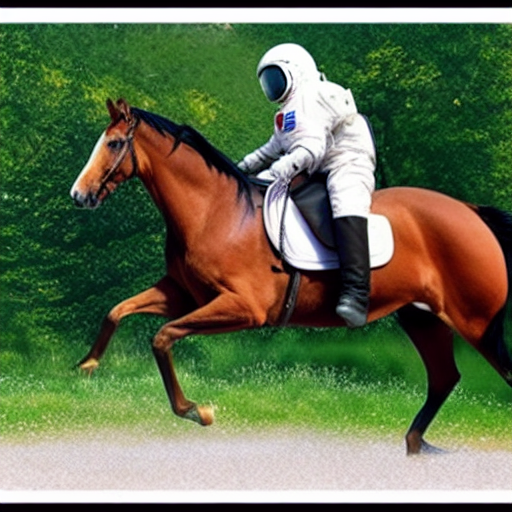

In [71]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image